In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import torchvision

##**Regression**##

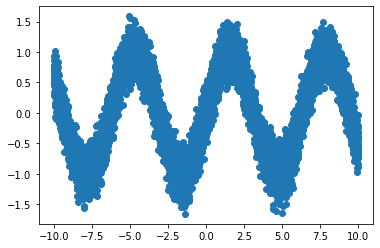

In [33]:
x = torch.linspace(start=-10, end=10, steps=10000).unsqueeze(1) # 10000 equally spaced values between [-10, 10]
y = torch.sin(x) + 0.2*torch.normal(mean=torch.zeros_like(x), std=torch.ones_like(x))
plt.scatter(x, y)
plt.show()

In [34]:
x_test = torch.linspace(start=-10, end=10, steps=5000).unsqueeze(1) 
y_test = torch.sin(x_test)

**Define the Thromposon Group F function as the activation function**

In [26]:
from torch.nn.functional import relu
def tfact(x):
    return relu(2*x) - relu(x-1/4) - relu(x/2 - 1/4)

class TFact(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return tfact(input)

In [29]:
model = torch.nn.Sequential(
            torch.nn.Linear(1, 100),
            TFact(),
            torch.nn.Linear(100,1000),
            TFact(),
            torch.nn.Linear(1000, 1)
        )

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
y_hat = model(x)

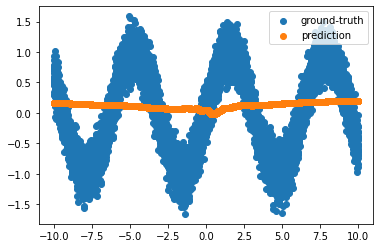

In [35]:
plt.scatter(x, y, label="ground-truth")
plt.scatter(x, y_hat.detach(), label="prediction")
plt.legend(loc="upper right")
plt.show()

In [36]:
L = torch.mean(((y_hat-y)**2))
print("The average loss or error in the model's predictions compared to the ground truth is %.4f" % (L))

The average loss or error in the model's predictions compared to the ground truth is 0.5310


In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
x=x.to(device)
y = y.to(device)

In [38]:
alpha = 0.01
error_tolerance = 0.04
i=0
while L > error_tolerance:
    # forward pass
    y_hat = model(x)
    L = torch.mean((y_hat-y)**2)
    if i%10 == 0:
        print(L.item())
    i += 1
    # backward pass
    optimizer.zero_grad()
    L.backward()
        
    # update parameters
    optimizer.step() 

0.5310150980949402
0.38314321637153625
0.29536548256874084
0.2355920821428299
0.1980854570865631
0.1671105921268463
0.147273451089859
0.1355804204940796
0.12828326225280762
0.12292394787073135
0.11803551763296127
0.11314740777015686
0.10834681987762451
0.10320307314395905
0.09807728230953217
0.09308479726314545
0.08927407115697861
0.08366769552230835
0.07999493181705475
0.07561612129211426
0.07989917695522308
0.07007481157779694
0.06609859317541122
0.06387677788734436
0.06278014183044434
0.05896694213151932
0.05710025504231453
0.06324680894613266
0.05680997297167778
0.05280798301100731
0.053843069821596146
0.04999888315796852
0.05054950341582298
0.05074325576424599
0.04871425777673721
0.04948005452752113
0.04689588397741318
0.046983059495687485
0.047343138605356216
0.04473331943154335
0.04888762906193733
0.05367681756615639
0.045081693679094315
0.044192224740982056
0.042823269963264465
0.04276015982031822
0.04240135848522186
0.05358968302607536
0.0476466566324234
0.04280068725347519
0.

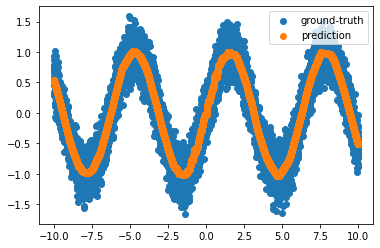

In [41]:
x = x.cpu()
y=y.cpu()
plt.scatter(x, y, label="ground-truth")
plt.scatter(x, y_hat.detach().cpu(), label="prediction")
plt.legend(loc="upper right")
plt.show()

##**Classification**##

In [10]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

train_dataset = datasets.MNIST('./mnist/MNIST_data/', download=True, train=True, transform=transform)
test_dataset = datasets.MNIST('./mnist/MNIST_data/', download=True, train=False, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

print(len(train_dataset), len(test_dataset))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST_data/MNIST/raw




Extracting ./mnist/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST_data/MNIST/raw




Extracting ./mnist/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST_data/MNIST/raw

Processing...
Done!
60000 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
from torchsummary import summary

model = torch.nn.Sequential(
            torch.nn.Linear(28*28, 1024),
            TFact(),
            torch.nn.Linear(1024,512),
            TFact(),
            torch.nn.Linear(512,10),
        )


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model,(784,))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def probabilties_from_scores(y):
    f = torch.nn.Softmax(dim=1)
    p = f(y)
    return p

def loss(y_hat, y):
    # y_hat has shape (N, 10) for 10 classes, y has shape (N,) 
    f = torch.nn.CrossEntropyLoss()
    return f(y_hat, y)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         803,840
             TFact-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
             TFact-4                  [-1, 512]               0
            Linear-5                   [-1, 10]           5,130
Total params: 1,333,770
Trainable params: 1,333,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 5.09
Estimated Total Size (MB): 5.11
----------------------------------------------------------------


In [12]:
def evaluate(dataloader, model, log=False):
    correct_count, total_count = 0, 0
    for images_batch, labels_batch in dataloader:
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
        images = images_batch.reshape(images_batch.shape[0], 28*28)
        scores = model(images)
        probabilities = probabilties_from_scores(scores)
        
        pred_label = probabilities.max(1, keepdim=True)[1]
        correct_count += pred_label.eq(labels_batch.view_as(pred_label)).sum().item()
        total_count += labels_batch.shape[0]

    if log:
        print("Number Of Images Tested =", total_count)
        print("Model Accuracy =", (correct_count/total_count))
    
    return (correct_count/total_count)

result = evaluate(test_dataloader, model, log=True)

Number Of Images Tested = 10000
Model Accuracy = 0.0832


In [13]:
epochs = 15
for epoch in range(epochs):
    running_loss = 0
    for images_batch, labels_batch in train_dataloader:
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
        images_batch = images_batch.reshape(images_batch.shape[0], 28*28)   # Flatten MNIST images into a 784 long vector
        # forward pass
        y_hat = model(images_batch)
        y = labels_batch
        L = loss(y_hat, y)
        
        # backward pass
        optimizer.zero_grad()
        L.backward()
        
        # update parameters
        optimizer.step()
        
        running_loss += L.item()
        
    training_loss = running_loss/len(train_dataloader)
    train_accuracy = evaluate(train_dataloader, model)
    test_accuracy = evaluate(test_dataloader, model)                                  
    
    if epoch % 1 == 0:
        print("Epoch {} - Training loss: {}  Train Accuracy: {}  Test Accuracy: {}".format(epoch, training_loss, train_accuracy, test_accuracy))
    
    if test_accuracy > 0.98:
      break

Epoch 0 - Training loss: 0.42301839333512126  Train Accuracy: 0.9312666666666667  Test Accuracy: 0.9314
Epoch 1 - Training loss: 0.24671091690961358  Train Accuracy: 0.9441333333333334  Test Accuracy: 0.941
Epoch 2 - Training loss: 0.22821134743568644  Train Accuracy: 0.94655  Test Accuracy: 0.9426
Epoch 3 - Training loss: 0.19778410219120732  Train Accuracy: 0.9418833333333333  Test Accuracy: 0.9383
Epoch 4 - Training loss: 0.20060124849257216  Train Accuracy: 0.94835  Test Accuracy: 0.9462
Epoch 5 - Training loss: 0.18734372943254518  Train Accuracy: 0.9532333333333334  Test Accuracy: 0.9469
Epoch 6 - Training loss: 0.1836793786123284  Train Accuracy: 0.9487333333333333  Test Accuracy: 0.9436
Epoch 7 - Training loss: 0.1761662705219599  Train Accuracy: 0.95455  Test Accuracy: 0.9504
Epoch 8 - Training loss: 0.17382533157141064  Train Accuracy: 0.9591833333333334  Test Accuracy: 0.9512
Epoch 9 - Training loss: 0.1642446978065346  Train Accuracy: 0.9569666666666666  Test Accuracy: 0.95

In [14]:
result = evaluate(test_dataloader, model, log=True)

Number Of Images Tested = 10000
Model Accuracy = 0.9494
